In [1]:
import pandas as pd
import re
from sqlalchemy import create_engine

# Database connection setup
db_config = {
    'host': '192.168.1.12',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'kaviyam123',
    'port': '5432'
}
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

# Step 1: Load data from PostgreSQL
query = 'SELECT * FROM "corrected_merged_claim_data_EF";'
data = pd.read_sql(query, con=engine)

C:\Users\HP\AppData\Local\Temp\ipykernel_18536\1244198774.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_18536\1244198774.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_18536\1244198774.py:16: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data[col] = pd.to_datetime(data[col], errors='coerce')
C:\Users\HP\AppData\Local\Temp\ipykernel_18536\1244198774.py:16: UserWarning: Coul

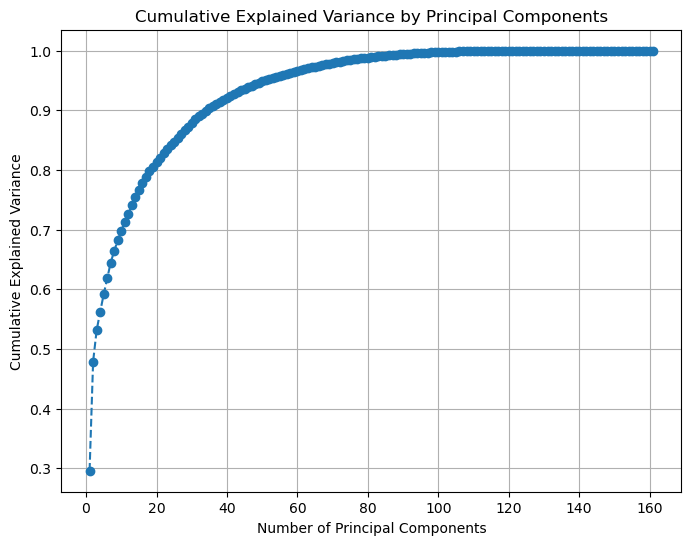

In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Fill missing values for both categorical and numerical columns
for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('missing')
    else:
        data[column] = data[column].fillna(0)

# Identify date columns by checking for columns that could represent dates
date_columns = [col for col in data.columns if 'date' in col.lower()]
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all identified date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year.fillna(0).astype(int)
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month.fillna(0).astype(int)
    new_date_cols[f'{col}_DAY'] = data[col].dt.day.fillna(0).astype(int)

# Use pd.concat to add these new columns efficiently
data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

# Drop the original date columns after extracting year, month, and day
data = data.drop(date_columns, axis=1)

# Label encode categorical columns
categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {}

for col in categorical_columns:
    # Ensure all values in the column are strings before encoding
    data[col] = data[col].astype(str)
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col])
    label_encoders[col] = le

# Standardize the data (numerical columns only)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.drop('Policy Status', axis=1, errors='ignore'))  

# Perform PCA without specifying n_components to visualize explained variance
pca = PCA()
pca.fit(data_scaled)

# Plot cumulative explained variance
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), 
         pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

In [3]:
# Choose a specific number of principal components based on the explained variance plot
pca = PCA(n_components=40)  # Adjust the number based on desired variance retention
principal_components = pca.fit_transform(data_scaled)

# Convert the PCA result back into a DataFrame for further analysis
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, 41)])
pca_df['Policy Status'] = data['Policy Status'].values  # Include the target column for reference

# Save the PCA results to CSV if needed
pca_df.to_csv('pca_result_reduced (up_selected) 40.csv', index=False)

# Calculate the sum of the absolute contributions of each feature across all components
original_feature_names = data.columns.drop('Policy Status')  # Exclude 'Status' from feature names
pca_components = pd.DataFrame(pca.components_, columns=original_feature_names)
feature_importance = pca_components.abs().sum(axis=0)

# Convert the feature importance to a DataFrame
feature_importance_df = pd.DataFrame(feature_importance, columns=['Total Contribution'])

# Sort features by their total contribution in descending order
sorted_feature_importance = feature_importance_df.sort_values(by='Total Contribution', ascending=False)

# Save the summed absolute contributions to a CSV file
sorted_feature_importance.to_csv('pca_feature_importance_summed (up_selected) 40.csv', index=True)

# Print the top 10 contributing features
print("Top 10 Contributing Features:\n", sorted_feature_importance.head(10))

Top 10 Contributing Features:
                                                  Total Contribution
Fuel Type                                                  4.284039
Add on Eligibilty (5th & 6th Renewals With NCB)            4.010957
Zone 2                                                     4.005948
Tie Up                                                     3.810408
MANUFACTURER/Make                                          3.786121
enginenumber                                               3.785790
NCB % Previous Year                                        3.769922
RTO Location                                               3.476618
Total TP Premium                                           3.373963
OEM Discount Category                                      3.294856


In [4]:
# Choose a specific number of principal components based on the explained variance plot
pca = PCA(n_components=20)  # Adjust the number based on desired variance retention
principal_components = pca.fit_transform(data_scaled)

# Convert the PCA result back into a DataFrame for further analysis
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, 21)])
pca_df['Policy Status'] = data['Policy Status'].values  # Include the target column for reference

# Save the PCA results to CSV if needed
pca_df.to_csv('pca_result_reduced (up_selected) 20.csv', index=False)

# Calculate the sum of the absolute contributions of each feature across all components
original_feature_names = data.columns.drop('Policy Status')  # Exclude 'Status' from feature names
pca_components = pd.DataFrame(pca.components_, columns=original_feature_names)
feature_importance = pca_components.abs().sum(axis=0)

# Convert the feature importance to a DataFrame
feature_importance_df = pd.DataFrame(feature_importance, columns=['Total Contribution'])

# Sort features by their total contribution in descending order
sorted_feature_importance = feature_importance_df.sort_values(by='Total Contribution', ascending=False)

# Save the summed absolute contributions to a CSV file
sorted_feature_importance.to_csv('pca_feature_importance_summed (up_selected) 20.csv', index=True)

# Print the top 10 contributing features
print("Top 10 Contributing Features:\n", sorted_feature_importance.head(10))

Top 10 Contributing Features:
                               Total Contribution
Last Year NCB                           1.931657
Applicable Discount with NCB            1.910676
Cleaned_New Branch Name 2               1.860755
New Branch Name  2                      1.857564
NCB % Previous Year                     1.819126
Tie Up                                  1.804728
Total Premium Payable                   1.773792
gst                                     1.773786
Policy Tenure(Check)                    1.758802
Policy Tenure                           1.758686


In [5]:
# Choose a specific number of principal components based on the explained variance plot
pca = PCA(n_components=30)  # Adjust the number based on desired variance retention
principal_components = pca.fit_transform(data_scaled)

# Convert the PCA result back into a DataFrame for further analysis
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, 31)])
pca_df['Policy Status'] = data['Policy Status'].values  # Include the target column for reference

# Save the PCA results to CSV if needed
pca_df.to_csv('pca_result_reduced (up_selected) 30.csv', index=False)

# Calculate the sum of the absolute contributions of each feature across all components
original_feature_names = data.columns.drop('Policy Status')  # Exclude 'Status' from feature names
pca_components = pd.DataFrame(pca.components_, columns=original_feature_names)
feature_importance = pca_components.abs().sum(axis=0)

# Convert the feature importance to a DataFrame
feature_importance_df = pd.DataFrame(feature_importance, columns=['Total Contribution'])

# Sort features by their total contribution in descending order
sorted_feature_importance = feature_importance_df.sort_values(by='Total Contribution', ascending=False)

# Save the summed absolute contributions to a CSV file
sorted_feature_importance.to_csv('pca_feature_importance_summed (up_selected) 30.csv', index=True)

# Print the top 10 contributing features
print("Top 10 Contributing Features:\n", sorted_feature_importance.head(10))

Top 10 Contributing Features:
                                                  Total Contribution
Zone 2                                                     3.254759
NCB % Previous Year                                        3.145762
Hyundai Discount Status                                    2.842437
OEM Discount Category                                      2.775895
Last Year NCB                                              2.752906
Add on Eligibilty (5th & 6th Renewals With NCB)            2.628116
null_count                                                 2.622895
Applicable Discount with NCB                               2.577150
enginenumber                                               2.494189
MANUFACTURER/Make                                          2.484637


In [6]:
# Choose a specific number of principal components based on the explained variance plot
pca = PCA(n_components=25)  # Adjust the number based on desired variance retention
principal_components = pca.fit_transform(data_scaled)

# Convert the PCA result back into a DataFrame for further analysis
pca_df = pd.DataFrame(data=principal_components, columns=[f'PC{i}' for i in range(1, 26)])
pca_df['Policy Status'] = data['Policy Status'].values  # Include the target column for reference

# Save the PCA results to CSV if needed
pca_df.to_csv('pca_result_reduced (up_selected) 25.csv', index=False)

# Calculate the sum of the absolute contributions of each feature across all components
original_feature_names = data.columns.drop('Policy Status')  # Exclude 'Status' from feature names
pca_components = pd.DataFrame(pca.components_, columns=original_feature_names)
feature_importance = pca_components.abs().sum(axis=0)

# Convert the feature importance to a DataFrame
feature_importance_df = pd.DataFrame(feature_importance, columns=['Total Contribution'])

# Sort features by their total contribution in descending order
sorted_feature_importance = feature_importance_df.sort_values(by='Total Contribution', ascending=False)

# Save the summed absolute contributions to a CSV file
sorted_feature_importance.to_csv('pca_feature_importance_summed (up_selected) 25.csv', index=True)

# Print the top 10 contributing features
print("Top 10 Contributing Features:\n", sorted_feature_importance.head(10))

Top 10 Contributing Features:
                                                  Total Contribution
NCB % Previous Year                                        2.662380
Zone 2                                                     2.572349
Hyundai Discount Status                                    2.537092
Last Year NCB                                              2.409759
OEM Discount Category                                      2.305448
Applicable Discount with NCB                               2.274764
MANUFACTURER/Make                                          2.139908
Add on Eligibilty (5th & 6th Renewals With NCB)            2.114496
Tie Up                                                     2.103149
Cleaned_New Branch Name 2                                  2.082070


In [1]:
import pandas as pd
import re
from sqlalchemy import create_engine

# Database connection setup
db_config = {
    'host': 'localhost',
    'database': 'postgres',
    'user': 'postgres',
    'password': 'kaviyam123',
    'port': '5432'
}
connection_string = f"postgresql://{db_config['user']}:{db_config['password']}@{db_config['host']}:{db_config['port']}/{db_config['database']}"
engine = create_engine(connection_string)

# Step 1: Load data from PostgreSQL
query = 'SELECT * FROM "corrected_merged_claim_data_EF";'
data = pd.read_sql(query, con=engine)

         LD1       LD2
0  -9.754446 -8.857018
1  30.721420  4.038571
2  -9.805030 -8.728634
3  -9.985804 -8.010223
4 -10.078038 -9.198038
Top Features by Importance:
                          Feature   Importance
62                         booked  1076.628867
138    Policy End Date_claim_Year  1037.187276
66                            nop   629.754840
135  Policy Start Date_claim_Year   506.045670
144              Settle date_Year   262.010265
147            Settled Month_Year   262.010265
126            Claim Happaned/Not   255.844993
149             Settled Month_Day   255.844993
150    DAT_REGISTRATION_DATE_Year   255.804178
141                Loss Date_Year   254.705860


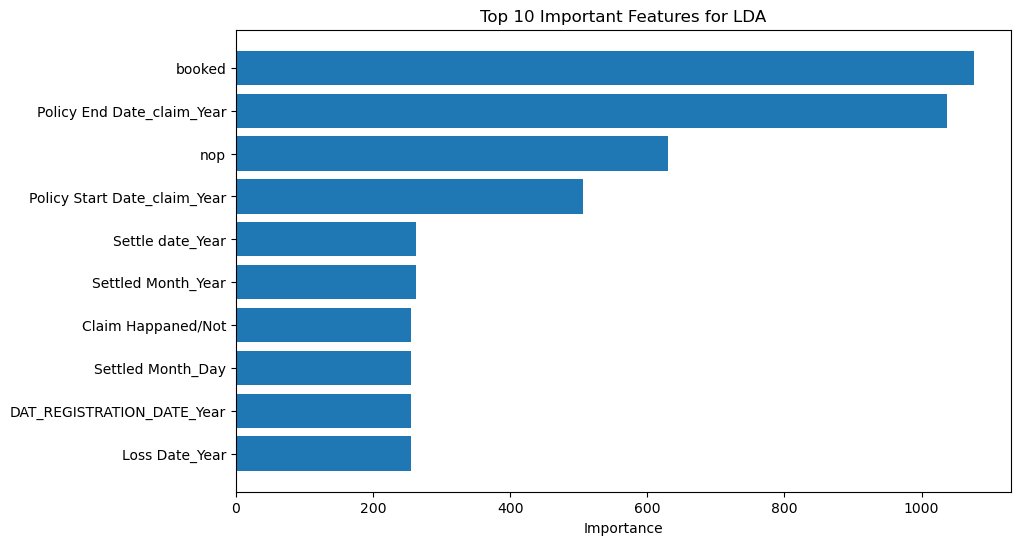

In [2]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import LabelEncoder, StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Handle date columns - Extract year, month, day
date_columns = data.select_dtypes(include=['datetime64']).columns.tolist()
for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')  # Convert to datetime
    data[f'{col}_Year'] = data[col].dt.year.fillna(0)
    data[f'{col}_Month'] = data[col].dt.month.fillna(0)
    data[f'{col}_Day'] = data[col].dt.day.fillna(0)

# Drop original date columns
data = data.drop(columns=date_columns)

# Separate the target column 'Policy Status'
target = data['Policy Status']

# Encode categorical columns into numerical values using LabelEncoder
categorical_columns = data.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))  # Encode each categorical column
    label_encoders[col] = le

# Fill missing values (NaN) with 0
data_filled = data.fillna(0)

# Standardize the data (only numerical columns)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data_filled.drop('Policy Status', axis=1, errors='ignore')) 

# Calculate the number of classes in the 'Policy Status' column
n_classes = target.nunique()

# Calculate the number of features in the scaled dataset
n_features = data_scaled.shape[1]

# Determine the maximum number of components for LDA
n_components = min(n_classes - 1, n_features)

# Apply LDA with the calculated number of components
lda = LDA(n_components=n_components)
principal_components = lda.fit_transform(data_scaled, target)  # LDA requires both features and target

# Convert the LDA result back into a DataFrame for further analysis
lda_df = pd.DataFrame(data=principal_components, columns=[f'LD{i}' for i in range(1, n_components + 1)])

# Save the LDA result to CSV for further analysis
lda_df.to_csv('lda_result_all_columns.csv', index=False)

# Display the first few rows of the LDA-transformed data
print(lda_df.head())

# Get the feature names and LDA coefficients
feature_names = data_filled.drop('Policy Status', axis=1, errors='ignore').columns
lda_coefficients = lda.coef_

# Compute feature importance based on the LDA coefficients
abs_coefficients = np.abs(lda_coefficients).sum(axis=0)
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': abs_coefficients})

# Sort by importance
sorted_feature_importance = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the most important features
print("Top Features by Importance:")
print(sorted_feature_importance.head(10))  # Display top 10 features

# Save the sorted feature importance to CSV
sorted_feature_importance.to_csv('lda_feature_importance_all_columns.csv', index=False)

# Visualize the top 10 most important features
plt.figure(figsize=(10, 6))
plt.barh(sorted_feature_importance['Feature'].head(10), sorted_feature_importance['Importance'].head(10))
plt.xlabel('Importance')
plt.title('Top 10 Important Features for LDA')
plt.gca().invert_yaxis()
plt.show()